In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [5]:
from matplotlib import pyplot as plt
import sys
from matplotlib import animation, rc
import scipy.sparse as sparse
import scipy.io as sio
import scipy.stats as stats
import scipy.spatial.distance as dist
import numpy as np
import h5py
from tqdm import tqdm
import pandas as pd
import imageio
import av
#import dlc_utils

#import tables
#import deepdish as dd

sys.path.append('/home/jma819/post_cmfe_analysis')
#sys.path.append('/Users/johnmarshall/Documents/Analysis/PythonAnalysisScripts/post_cmfe_analysis')
import python_utils_jjm as utils_jjm
import create_analysis_videos_module as cav


In [6]:
## create analysis videos using module functions 

In [8]:
session = 'GRIN039_H12_M33_S29'

In [9]:
#need to get keys first from all session dataframes to read into pandas
h5file=pd.HDFStore('/projects/b1118/miniscope/analysis/event_analysis/movement_regions_for_display_2.h5')
keys=h5file.keys()
h5file.close()
#load fluorescence in event regions
z_scored_events_by_session = {key_idx.strip('/'):pd.read_hdf('/projects/b1118/miniscope/analysis/event_analysis/movement_regions_for_display_2.h5', key=key_idx) for key_idx in keys}
#load spatial components 
spatial_h5file=h5py.File('/projects/b1118/miniscope/analysis/spatial_data/spatial_components_test.h5', 'r')
spatial_contours = {session:spatial_h5file[session][:] for session in list(spatial_h5file.keys())}
spatial_h5file.close()
#velocity data
velocity_data_all_sessions = pd.read_hdf('/projects/b1118/miniscope/analysis/event_analysis/compiled_velocity_all_sessions.h5')

In [115]:
event_start_indicies_in_session = utils_jjm.return_list_of_level_indicies_in_session(z_scored_events_by_session[session].loc['z_scored_movement_regions'], 0)
event_end_indicies_in_session = utils_jjm.return_list_of_level_indicies_in_session(z_scored_events_by_session[session].loc['z_scored_movement_regions'], 1)
event_bounds = [event_bound for event_bound in zip(event_start_indicies_in_session, event_end_indicies_in_session)]

In [118]:
event_start_indicies_in_session

[Timedelta('0 days 00:00:01.400000')]

In [119]:
#if trimming video further for display
selected_event = 0 
video_event_bounds = (event_bounds[selected_event][0]+pd.to_timedelta(8, unit='s'), 
                      event_bounds[selected_event][1]-pd.to_timedelta(6, unit='s'))
video_event_bounds

(Timedelta('0 days 00:00:09.400000'), Timedelta('0 days 00:00:15.800000'))

In [120]:
#velocity data for session
velocity_data_for_session = velocity_data_all_sessions.loc[session]

In [121]:
#spatial contours for all cells 
session_spatial_contours = spatial_contours[session][:, :]
all_cell_contours = session_spatial_contours[:, :]
#flourscence data
c_data_session = z_scored_events_by_session[session]
event_trace = c_data_session.loc['z_scored_movement_regions'].loc[event_bounds[selected_event][0]].loc[event_bounds[selected_event][1]]

In [122]:
np.shape(all_cell_contours)

(360960, 40)

In [123]:
#selecting further subset for display 
event_trace_for_video = event_trace.loc[int(8/.2):int(14/.2)]

In [124]:
#event_trace_for_video.reset_index(drop=True)

In [125]:
cells_recombined = cav.generate_event_movie_for_all_cells(event_trace_for_video.reset_index(drop=True), all_cell_contours)

100%|██████████| 38/38 [00:07<00:00,  4.90it/s]


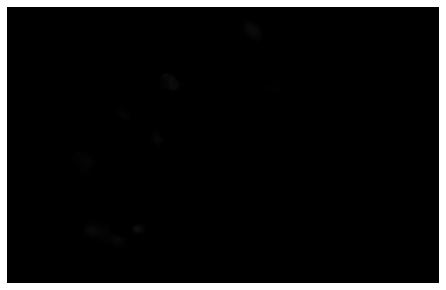

In [126]:
fig, ax1 = plt.subplots(1,1)
in_vmax = np.max(cells_recombined)
im = ax1.imshow(cells_recombined[0,:,:], cmap='gray', vmin=0, vmax=in_vmax)
ax1.axis('off')
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
#animation functions 
def init():
    im.set_data(cells_recombined[0,:,:])
def animate(i):
    im.set_data(cells_recombined[i,:,:])
    return (im)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=cells_recombined.shape[0], interval=50)
rc('animation', html='jshtml')

In [127]:
anim

In [33]:
#!python --version
#!source activate caiman_with_tables
!conda install -c conda-forge ffmpeg-python

Fetching package metadata .............
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /home/jma819/.conda/envs/caiman_with_tables:
#
ffmpeg-python             0.2.0                      py_0    conda-forge


In [90]:
#may have to reinstall ffmpeg on qnode if in cluser, be sure to activate environment first
mywriter = animation.FFMpegWriter(fps=5)
anim.save('/projects/b1118/miniscope/analysis/event_videos/example_videos/'+session+'_event_'+str(video_event_bounds[0])[7:]+'_all_cells_08222021'+'.mp4', 
              writer=mywriter)

In [91]:
## to create matched behavior video

In [92]:
time_delta_for_msCam_resampled = list(pd.timedelta_range(start=video_event_bounds[0], end=video_event_bounds[1], freq='.2S'))


In [93]:
times_in_velocity_trace = [dlc_utils.nearest(velocity_data_for_session.index, time_delta_msCam) for time_delta_msCam in time_delta_for_msCam_resampled]

In [94]:
#get the behav cam frame indicies for the times in times in velocity trace 
behav_cam_indicies = [int(velocity_data_for_session.loc[td]['behavCam_frames']%1000) for td in times_in_velocity_trace]
#get num of behavCam video
behavCam_video = int((velocity_data_for_session.loc[times_in_velocity_trace[0]]['behavCam_frames'])/1000)+1
behavCam_video_2 = int((velocity_data_for_session.loc[times_in_velocity_trace[-1]]['behavCam_frames'])/1000)+1
#call function to get behavCam clip
behav_cam_clip = cav.load_and_return_behavCam_video(behav_cam_indicies, behavCam_video, session)






Frame: 0/1000 ...


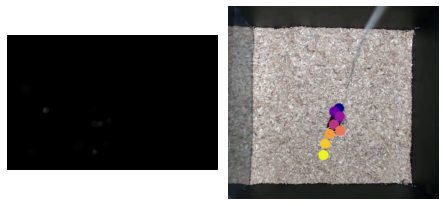

In [95]:

fig, (ax1, ax2) = plt.subplots(1,2)
plt.subplots_adjust(wspace=0.05)
in_vmax = np.max(cells_recombined)
im = ax1.imshow(cells_recombined[0,:,:], cmap='gray', vmin=0, vmax=in_vmax)
im2 = ax2.imshow(behav_cam_clip[0])
ax1.axis('off')
ax2.axis('off')
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
#animation functions 
def init():
    im.set_data(cells_recombined[0,:,:])
    im2.set_data(behav_cam_clip[0])
def animate(i):
    im.set_data(cells_recombined[i,:,:])
    im2.set_data(behav_cam_clip[i])
    return (im, im2)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=cells_recombined.shape[0], interval=50)
rc('animation', html='jshtml')





In [96]:
anim

In [65]:
mywriter = animation.FFMpegWriter(fps=5)
anim.save('/projects/b1118/miniscope/analysis/event_videos/example_videos/'+session+'_event_'+str(video_event_bounds[0])[7:]+'_all_cells_withbehavior_08222021'+'.mp4', 
              writer=mywriter)

In [ ]:
## "manually" from cmfe files 

In [8]:
results_file = '/Volumes/My_Passport/cnmfe_analysis_files/batch_output_files/29-Mar_21_42_20_out.mat'

In [9]:
results_file.split('/')[-1]

'29-Mar_21_42_20_out.mat'

In [10]:
results_file[0:-4]+'_demixed_color.h5'

'/Volumes/My_Passport/cnmfe_analysis_files/batch_output_files/29-Mar_21_42_20_out_demixed_color.h5'

In [11]:
results = sio.loadmat(results_file)

##A is spatial contours

In [12]:
#img_file = '/Users/johnmarshall/Documents/Analysis/MiniscopeMovies/GRIN011/H10_M19_S59msCam1.tif'
#img_from_file = plt.imread(img_file)    
#d1, d2 = np.shape(img_from_file)
d1, d2 = 480, 752

In [13]:
dense_A = results['A'].todense()

In [14]:
frames = np.shape(results['C'])[1]

In [15]:
cells = np.shape(results['C'])[0]

In [25]:
results['C'][10, 10]

0.21207764157814804

In [26]:
color_eg = results['C'][10, 10]*np.array([255, 128, 0])

In [27]:
color_eg

array([54.0797986 , 27.14593812,  0.        ])

In [31]:
#reshape for all frames
frame_range = (100, 150)
cells_reshaped = np.empty((cells, frame_range[1]-frame_range[0], d1, d2))
for cell in tqdm(range(cells)):
    A_reshaped = np.reshape(dense_A[:, cell], (d1, d2))
    cells_reshaped[cell] = np.array([np.dot(A_reshaped, results['C'][cell, frame]) for frame in range(frame_range[0], frame_range[1])])
    


 33%|███▎      | 49/148 [00:16<00:36,  2.74it/s]

KeyboardInterrupt: 

In [34]:
#to add color use RBGA, where each pixel has 3 values for RBG and last for intensity
frame_range = (100, 150)
cells_reshaped_color = np.empty((cells, frame_range[1]-frame_range[0], d1, d2, 4))
for cell in tqdm(range(cells)):
    A_reshaped = np.reshape(dense_A[:, cell], (d1, d2))
    cell_frames = []
    for frame in range(frame_range[0], frame_range[1]):
        cell_frames.append(np.array([np.dot(A_reshaped, item) for item in [255, 128, 0, results['C'][cell, frame]]]))
    



100%|██████████| 148/148 [01:12<00:00,  2.04it/s]


In [19]:
np.shape(cells_reshaped)

(148, 50, 480, 752)

In [20]:
cells_recombined = np.sum(cells_reshaped, axis=0)

In [21]:
np.shape(cells_recombined)

(50, 480, 752)

In [24]:
np.shape(cells_recombined[1])

(480, 752)

In [18]:
hf = h5py.File(results_file[0:-4]+'_demixed_.h5', 'w')

In [19]:
hf.create_dataset('demixed_movie_array', data=cells_reshaped )

<HDF5 dataset "demixed_movie_array": shape (148, 50, 480, 752), type "<f8">

In [20]:
hf.close()

In [21]:
cells_recombined = np.sum(cells_reshaped, axis=0)

In [23]:
imageio.mimwrite(results_file[0:-4]+'_demixed_.mp4', cells_recombined, fps = 20)

Lossy conversion from float64 to uint8. Range [-0.3798849567984799, 12.091775452771081]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 11.713751442333251]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.8520886023244922, 11.34831881789857]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.2384764332364273, 11.557402771284801]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-2.0497256521789264, 11.439661809377398]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 11.32280260335843]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.7103066350561602, 10.968474789416469]. Convert image to uint

In [5]:
## recombine demixed video with behavior data 
cnmfe_range = (0, 150)
dir_path = '/Volumes/My_Passport/cnmfe_analysis_files/GRIN011/'
frame_clock_info = 'timestamp.dat'
frame_clock_df = pd.read_table(dir_path+frame_clock_info)

# load time stamps 
msCam_timestamps = frame_clock_df[frame_clock_df['camNum'] == 0].set_index('frameNum')[cnmfe_range[0]:cnmfe_range[1]]
behavCam_timestamps = frame_clock_df[frame_clock_df['camNum'] == 1].set_index('frameNum')
# reset initial clock value to 0 
msCam_timestamps['sysClock'][1] = 0
behavCam_timestamps['sysClock'][1] = 0

/Users/johnmarshall/miniconda3/envs/caiman/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """


In [7]:
# create df to find matched behavior cam frames
msCam_timestamps = jjm_utils.align_behavior_data(msCam_timestamps, behavCam_timestamps)
msCam_timestamps.reset_index(inplace=True)
msCam_timestamps.head()

100%|██████████| 150/150 [00:01<00:00, 89.27it/s]


frameNum  camNum  sysClock  buffer  behavCam_frames  sys_clock_behavCam
0         1       0         0       1                1                   0
1         2       0         7       1                1                   0
2         3       0        58       1                3                  47
3         4       0       108       1                5                 111
4         5       0       158       1                6                 143

In [9]:
# 
reader = imageio.get_reader('/Volumes/My_Passport/cnmfe_analysis_files/GRIN011/behavCam1.avi')

In [18]:
bd1, bd2 = reader.get_meta_data()['size']

In [28]:
1 in msCam_timestamps['behavCam_frames'].values

True

In [35]:
behavior_adjusted = np.empty((cnmfe_range[1], bd2, bd1, 3))    
#for frame in range(cnmfe_range[0], cnmfe_range[1])
frame = 0
for i, im in enumerate(reader):
    if 1 in msCam_timestamps['behavCam_frames'].values:
        behavior_adjusted[0] = im
        

In [36]:
# combine those matched frames into a video

imageio.mimwrite('/Volumes/My_Passport/cnmfe_analysis_files/GRIN011/behavior_adjusted.mp4', behavior_adjusted, fps = 20)